In [25]:
%load_ext autoreload
%autoreload 2
%aimport

!nvidia-smi


Modules to reload:
all-except-skipped

Modules to skip:

Wed Apr 14 01:06:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   36C    P0    36W / 300W |   3019MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                   

In [26]:
prfxs = ["trn0008", "trn0007","trn0006"] 
imgszes = [224, 512, 512]
enet_types = ["tf_efficientnet_b1_ns", "tf_efficientnet_b4_ns", "tf_efficientnet_b3_ns"]
ckpts = [
    "0_0/checkpoints/epoch=10-step=3640.ckpt",
    "0_0/checkpoints/epoch=23-step=34943.ckpt",
    "0_0/checkpoints/epoch=24-step=9099.ckpt"
]

# tfidf

In [27]:
import numpy as np, pandas as pd, gc
import cv2, matplotlib.pyplot as plt
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors
print('RAPIDS',cuml.__version__)

RAPIDS 0.18.0


In [28]:
def get_targets(df):
    grp2ids = df.groupby("label_group").posting_id.agg("unique").to_dict()
    targets = df.label_group.map(grp2ids)
    return targets


In [29]:
HOME = "/data/git/shopee-product-matching"
p_prp = f'{HOME}/output/prep002'
FOLD = 0
FP16 = True
df = pd.read_csv(f'{p_prp}/df_valid.csv')
pids = df.posting_id.values

targets = get_targets(df)

In [30]:
df_cu = cudf.DataFrame(df)
model = TfidfVectorizer(stop_words='english', binary=True, max_features=25_000)
text_embeddings = model.fit_transform(df_cu.title).toarray()

In [31]:
preds = []
CHUNK = 1024*4

print('Finding similar titles...')
CTS = len(df_cu)//CHUNK
if len(df_cu)%CHUNK!=0: CTS += 1
for j in range( CTS ):
    
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(df_cu))
    print('chunk',a,'to',b)
    
    # COSINE SIMILARITY DISTANCE
    cts = cupy.matmul( text_embeddings, text_embeddings[a:b].T).T
    
    for k in range(b-a):
        IDX = cupy.where(cts[k,]>0.7)[0]
        o = df_cu.iloc[cupy.asnumpy(IDX)].posting_id.values_host
        preds.append(o)
        
del model, text_embeddings
_ = gc.collect()

Finding similar titles...
chunk 0 to 4096
chunk 4096 to 5135


In [53]:
preds_t = preds

In [54]:
preds_t[:30]

[array(['train_1802986387', 'train_2490201622'], dtype=object),
 array(['train_1806152124'], dtype=object),
 array(['train_3009013664', 'train_599478601', 'train_236461645',
        'train_3448377589'], dtype=object),
 array(['train_2985955659'], dtype=object),
 array(['train_2238403912'], dtype=object),
 array(['train_1180155871', 'train_3269870940'], dtype=object),
 array(['train_3466601092'], dtype=object),
 array(['train_1572286671'], dtype=object),
 array(['train_3117535609'], dtype=object),
 array(['train_1617041019'], dtype=object),
 array(['train_3697474443', 'train_2003670906', 'train_942029375'],
       dtype=object),
 array(['train_3350934785', 'train_1675185549'], dtype=object),
 array(['train_363659042'], dtype=object),
 array(['train_3122040273'], dtype=object),
 array(['train_3286978516'], dtype=object),
 array(['train_472067494', 'train_1931459725', 'train_857065549',
        'train_464408383', 'train_888029874'], dtype=object),
 array(['train_951314265', 'train_3670675

# setup

In [35]:
HOME = "/data/git/shopee-product-matching"
p_prp = f'{HOME}/output/prep002'

FOLD = 0
FP16 = True

import sys
sys.path.append(f"{HOME}/src")

import pandas as pd
from pl_model import ShpModel
import os
import torch
import numpy as np
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"

from final import enet_arcface_FINAL, load_model

from dataset import ShopeeDataset, get_transforms
from torch.utils.data import DataLoader


## utils

In [36]:
import numpy as np

def getf1(x, y):
    n = len(np.intersect1d(x, y))
    return 2 * n / (len(x) + len(y))


def getf1s(xs, ys):
    return (getf1(x, y) for x, y in zip(xs, ys))


def meanf1(xs, ys):
    return np.mean(list(getf1s(xs, ys)))


def get_targets(df):
    grp2ids = df.groupby("label_group").posting_id.agg("unique").to_dict()
    targets = df.label_group.map(grp2ids)
    return targets

def preds2pids(preds, pids):
    return [pids[o] for o in preds]


def comb_preds(*preds):
    return (np.unique(np.concatenate(l)) for l in zip(*preds))


# load model

In [37]:
df = pd.read_csv(f'{p_prp}/df_valid.csv')
pids = df.posting_id.values

targets = get_targets(df)

In [38]:
device = torch.device('cuda')
featss = []
for imdl in range(len(prfxs)):
    prfx = prfxs[imdl]
    imgsz = imgszes[imdl]
    enet_type = enet_types[imdl]
    ckpt = ckpts[imdl]
    shpmodel = ShpModel.load_from_checkpoint(f'{HOME}/output/{prfx}/tensorboard_csv/{ckpt}')
    out_dim = shpmodel.num_classes
    
    
    model = enet_arcface_FINAL(enet_type, out_dim=out_dim).to(device)
    model = load_model(model, shpmodel)
    model = model.to(device)
    
    
    
    tfms_trn, tfms_val = get_transforms(imgsz)
    ds = ShopeeDataset(df, mode="test", transform=tfms_val)
    dl = DataLoader(ds,
                batch_size=32,
                num_workers=8,
                pin_memory=True,
            )

    feats = np.zeros((len(ds), 512))
    i = 0
    for dat in tqdm(dl):
        with torch.no_grad():
            dat = dat.to(device)
            feat,_ = model(dat)
            l = len(feat)
            feats[i : i + l, :] = feat.cpu().detach().numpy()
            i += l
            
    featss.append(feats)
    

100%|██████████| 161/161 [00:33<00:00,  4.83it/s]


In [39]:
len(featss)

3

# inference

In [40]:
from cuml.neighbors import NearestNeighbors
import numpy as np
import torch.nn.functional as F


N_NBRS = 50
CHUNK = 1024 * 4


def mk_nnmdl(feats, n_nbrs=N_NBRS):
    nnmdl = NearestNeighbors(N_NBRS, metric="cosine")
    nnmdl.fit(feats)
    return nnmdl


def get_nbrs_from_nnmdl(feats, nnmdl, sz_chunk=CHUNK):
    n = len(feats)
    n_nbrs = nnmdl.n_neighbors
    dists = np.zeros((n, n_nbrs), dtype="float")
    idx = np.zeros((n, n_nbrs), dtype="int")
    n_chunks = len(feats) // sz_chunk
    if len(feats) % sz_chunk != 0:
        n_chunks += 1
    for j in tqdm(range(n_chunks)):
        a = j * sz_chunk
        b = (j + 1) * sz_chunk
        b = min(b, len(feats))
        dists_, idx_ = nnmdl.kneighbors(
            feats[
                a:b,
            ]
        )
        dists[a:b] = np.array(dists_)
        idx[a:b] = np.array(idx_)
    return dists, idx


def get_nbrs(feats, n_nbrs=N_NBRS, sz_chunk=CHUNK):
    nnmdl = mk_nnmdl(feats, n_nbrs)
    dists, idx = get_nbrs_from_nnmdl(feats, nnmdl, sz_chunk)
    return dists, idx


def get_preds_by_thrsh(dists, idx, thrsh):
    preds = (ind[dst < thrsh] for dst, ind in zip(dists, idx))
    return preds


def find_best(dists, idx, thrshes=np.linspace(0.,1.,num=21)):
    f1_lst = []
    preds_lst = []
    for thrsh in tqdm(thrshes):
        preds = get_preds_by_thrsh(dists, idx, thrsh)
        preds = preds2pids(preds, pids)
        preds_lst.append(preds)
        f1 = meanf1(preds,targets)
        f1_lst.append(f1)
    f1_best, thrsh_best, preds_best = sorted(zip(f1_lst, thrshes, preds_lst), reverse=True)[0]
    res = {'f1_best': f1_best, 
           'thrsh_best': thrsh_best, 
           'preds_best': preds_best, 
           'thrshes': thrshes, 
           'f1_lst': f1_lst}
    return res

In [41]:
feats_conc = np.concatenate(featss, 1)
feats_conc = F.normalize(torch.tensor(feats_conc))
feats_conc = feats_conc.numpy()

In [42]:
feats_conc.shape

(5135, 1536)

In [43]:
nbrs = get_nbrs(feats_conc)

100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


In [44]:
dists, idx = nbrs
res = find_best(dists, idx)
print(f"{res['f1_best']:.3f}, {res['thrsh_best']:.2f} ")

100%|██████████| 21/21 [00:03<00:00,  5.33it/s]

0.778, 0.60 


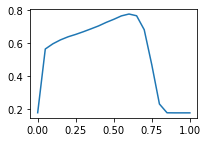

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(res['thrshes'], res['f1_lst'])  
plt.show()

In [46]:
preds_v = res['preds_best']

In [47]:
meanf1(preds_v, targets)

0.7775667718990791

In [62]:
preds_v[:30]

[array(['train_1802986387'], dtype=object),
 array(['train_1806152124'], dtype=object),
 array(['train_3009013664', 'train_3448377589'], dtype=object),
 array(['train_2985955659', 'train_4156734436', 'train_3916258742'],
       dtype=object),
 array(['train_2238403912', 'train_2095062361'], dtype=object),
 array(['train_1180155871'], dtype=object),
 array(['train_3466601092', 'train_354147588', 'train_96041043'],
       dtype=object),
 array(['train_3117535609', 'train_1572286671', 'train_3219773229'],
       dtype=object),
 array(['train_3117535609', 'train_1572286671', 'train_3219773229'],
       dtype=object),
 array(['train_1617041019'], dtype=object),
 array(['train_3697474443', 'train_942029375', 'train_2003670906'],
       dtype=object),
 array(['train_3350934785', 'train_1675185549'], dtype=object),
 array(['train_363659042', 'train_4224125539', 'train_3155443042'],
       dtype=object),
 array(['train_3122040273', 'train_1665497995'], dtype=object),
 array(['train_3286978516',

# hsh

In [48]:
def get_preds_pids_h(df):
    hsh2ids = df.groupby("image_phash").posting_id.agg("unique").to_dict()
    preds_h = df.image_phash.map(hsh2ids)
    return preds_h

In [49]:
preds_h = get_preds_pids_h(df)

In [50]:
meanf1(preds_h, targets)

0.5415179652897422

# combine

In [59]:
preds_comb = list(comb_preds(preds_v, preds_t))

meanf1(preds_comb, targets)

0.8227933589771607

In [61]:
preds_comb[:30]

[array(['train_1802986387', 'train_2490201622'], dtype=object),
 array(['train_1806152124'], dtype=object),
 array(['train_236461645', 'train_3009013664', 'train_3448377589',
        'train_599478601'], dtype=object),
 array(['train_2985955659', 'train_3916258742', 'train_4156734436'],
       dtype=object),
 array(['train_2095062361', 'train_2238403912'], dtype=object),
 array(['train_1180155871', 'train_3269870940'], dtype=object),
 array(['train_3466601092', 'train_354147588', 'train_96041043'],
       dtype=object),
 array(['train_1572286671', 'train_3117535609', 'train_3219773229'],
       dtype=object),
 array(['train_1572286671', 'train_3117535609', 'train_3219773229'],
       dtype=object),
 array(['train_1617041019'], dtype=object),
 array(['train_2003670906', 'train_3697474443', 'train_942029375'],
       dtype=object),
 array(['train_1675185549', 'train_3350934785'], dtype=object),
 array(['train_3155443042', 'train_363659042', 'train_4224125539'],
       dtype=object),
 arra

In [56]:
preds_comb = comb_preds(preds_v, preds_t, preds_h)

meanf1(preds_comb, targets)

0.8226895932871909

# fin

In [62]:
!nvidia-smi

Mon Apr 12 01:35:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   38C    P0    39W / 300W |   9064MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  